In [1]:
ENV["PYTHONPATH"] = "/home/shinaoka/sharehome/git/xfac/build/python"
using PyCall
xfacpy = pyimport("xfacpy")
using QuanticsTCI
using SparseIR
import SparseIR: valueim
using Plots
using ITensors
ITensors.disable_warn_order()

14

In [2]:
function tobins(i, nbit)
    @assert 1 ≤ i ≤ 2^nbit
    mask = 1 << (nbit-1)
    bin = ones(Int, nbit)
    for n in 1:nbit
        bin[n] = (mask & (i-1)) >> (nbit-n) + 1
        mask = mask >> 1
    end
    return bin
end

function frombins(bin)
    @assert all(1 .≤ bin .≤ 2)
    nbit = length(bin)
    i = 1
    tmp = 2^(nbit-1)
    for n in eachindex(bin)
        i += tmp * (bin[n] -1)
        tmp = tmp >> 1
    end
    return i
end

@assert frombins(tobins(4, 10)) == 4

In [3]:
beta = 1000.0

#ek(kx) = 2*cos(kx)
ek(k) = 2*cos(k) + 2*cos(20k) + cos(5k)

v = FermionicFreq(1)
iv = valueim(v, beta)

gk(kx::Float64) = 1 / (iv - ek(kx))

function gkb(b)
    nbit = length(b)
    N = 2^nbit
    ikx = frombins(b)
    @assert ikx ≤ N
    kx = 2π * (ikx - 1)/N
    return abs.(gk(kx))
end

gkb (generic function with 1 method)

In [4]:
nbit = 14
N = 2^nbit

gkdata = zeros(ComplexF64, N)
for ikx in 1:N
    bx = tobins(ikx, nbit)
    gkdata[ikx] = gkb(bx)
end

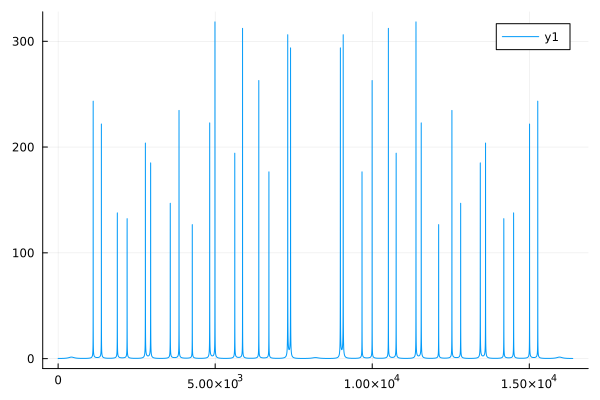

In [5]:
plot(abs.(gkdata))

In [6]:
firstpivot = ones(Int, nbit)
@show firstpivot
qtt, ranks, errors = QuanticsTCI.qtt(
    b -> gkb(b .+ 1),
    2,
    firstpivot;
    cutoff=1e-8, maxiter=200
)
;

firstpivot = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
10	10	27044.913984644558
20	20	6851.241930347878
30	30	455.1933343136897
40	40	528.6194909874256
50	50	2.02165671219259e-5


In [7]:
sites =  [Index(2, "Qubit,k=$k") for k in 1:nbit]
mps = QuanticsTCI.qtt_to_mps(qtt, sites)

MPS
[1] ((dim=2|id=763|"Qubit,k=1"), (dim=2|id=381|"link"))
[2] ((dim=2|id=381|"link"), (dim=2|id=393|"Qubit,k=2"), (dim=4|id=557|"link"))
[3] ((dim=4|id=557|"link"), (dim=2|id=640|"Qubit,k=3"), (dim=8|id=623|"link"))
[4] ((dim=8|id=623|"link"), (dim=2|id=199|"Qubit,k=4"), (dim=16|id=834|"link"))
[5] ((dim=16|id=834|"link"), (dim=2|id=19|"Qubit,k=5"), (dim=32|id=251|"link"))
[6] ((dim=32|id=251|"link"), (dim=2|id=477|"Qubit,k=6"), (dim=56|id=151|"link"))
[7] ((dim=56|id=151|"link"), (dim=2|id=7|"Qubit,k=7"), (dim=56|id=14|"link"))
[8] ((dim=56|id=14|"link"), (dim=2|id=266|"Qubit,k=8"), (dim=56|id=121|"link"))
[9] ((dim=56|id=121|"link"), (dim=2|id=38|"Qubit,k=9"), (dim=32|id=824|"link"))
[10] ((dim=32|id=824|"link"), (dim=2|id=794|"Qubit,k=10"), (dim=16|id=722|"link"))
[11] ((dim=16|id=722|"link"), (dim=2|id=4|"Qubit,k=11"), (dim=8|id=645|"link"))
[12] ((dim=8|id=645|"link"), (dim=2|id=456|"Qubit,k=12"), (dim=4|id=172|"link"))
[13] ((dim=4|id=172|"link"), (dim=2|id=267|"Qubit,k=13"), (

2 ^ (nbit / 2) = 128.0


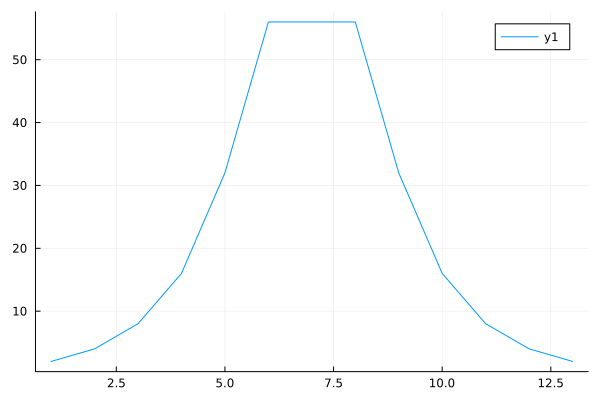

In [8]:
@show 2^(nbit/2)
plot(ITensors.dim.(linkinds(mps)))

In [9]:
gkdata_reconst = vec(Array(reduce(*, mps), reverse(sites)))

16384-element Vector{Float64}:
 0.1999999605209151
 0.20000239303884415
 0.20000969085704184
 0.2000218545943609
 0.20003888533887298
 0.200060784601654
 0.20008755435081332
 0.2001191969575589
 0.20015571519791184
 0.20019711237818932
 0.20024339216325537
 0.20029455867168186
 0.20035061646174002
 ⋮
 0.2003506164607787
 0.20029455866063556
 0.20024339216049655
 0.20019711237638377
 0.20015571519666084
 0.20011919693620556
 0.20008755434438666
 0.2000607846056439
 0.20003888533842
 0.20002185459483826
 0.20000969085955247
 0.20000239305060483

norm(gkdata_reconst .- gkdata) = 3.32014614640259e-5


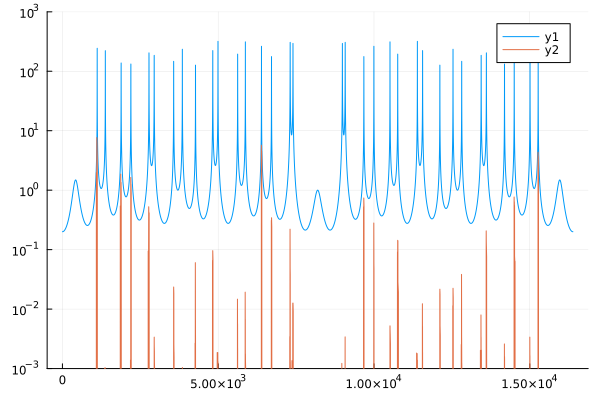

In [10]:
@show norm(gkdata_reconst .- gkdata)
p = plot(yscale=:log10, ylims=(1e-3, 1e+3))
plot!(p, abs.(gkdata))
plot!(p, 1e+6 * abs.(gkdata_reconst .- gkdata))

In [11]:
mps2 = MPS(ITensor(gkdata, reverse(sites)), sites; cutoff=1e-18)

MPS
[1] ((dim=2|id=763|"Qubit,k=1"), (dim=2|id=505|"Link,n=1"))
[2] ((dim=2|id=505|"Link,n=1"), (dim=2|id=393|"Qubit,k=2"), (dim=4|id=674|"Link,n=2"))
[3] ((dim=4|id=674|"Link,n=2"), (dim=2|id=640|"Qubit,k=3"), (dim=8|id=721|"Link,n=3"))
[4] ((dim=8|id=721|"Link,n=3"), (dim=2|id=199|"Qubit,k=4"), (dim=16|id=557|"Link,n=4"))
[5] ((dim=16|id=557|"Link,n=4"), (dim=2|id=19|"Qubit,k=5"), (dim=32|id=564|"Link,n=5"))
[6] ((dim=32|id=564|"Link,n=5"), (dim=2|id=477|"Qubit,k=6"), (dim=50|id=654|"Link,n=6"))
[7] ((dim=50|id=654|"Link,n=6"), (dim=2|id=7|"Qubit,k=7"), (dim=49|id=629|"Link,n=7"))
[8] ((dim=49|id=629|"Link,n=7"), (dim=2|id=266|"Qubit,k=8"), (dim=48|id=956|"Link,n=8"))
[9] ((dim=48|id=956|"Link,n=8"), (dim=2|id=38|"Qubit,k=9"), (dim=32|id=788|"Link,n=9"))
[10] ((dim=32|id=788|"Link,n=9"), (dim=2|id=794|"Qubit,k=10"), (dim=16|id=81|"Link,n=10"))
[11] ((dim=16|id=81|"Link,n=10"), (dim=2|id=4|"Qubit,k=11"), (dim=8|id=309|"Link,n=11"))
[12] ((dim=8|id=309|"Link,n=11"), (dim=2|id=456|"Qubi

In [12]:
gkdata_reconst2 = vec(Array(reduce(*, mps2), reverse(sites)))

16384-element Vector{ComplexF64}:
 0.19999996996196148 + 0.0im
 0.20000236920683764 + 0.0im
 0.20000969132692353 + 0.0im
 0.20002186395393917 + 0.0im
 0.20003891203643234 + 0.0im
 0.20006078561435087 + 0.0im
  0.2000875395092533 + 0.0im
  0.2001191829335006 + 0.0im
 0.20015571914768618 + 0.0im
 0.20019711507007754 + 0.0im
 0.20024338993915505 + 0.0im
 0.20029455266687107 + 0.0im
  0.2003506222418452 + 0.0im
                     ⋮
 0.20035062465391484 + 0.0im
 0.20029454755387638 + 0.0im
  0.2002433873144012 + 0.0im
 0.20019711484089842 + 0.0im
  0.2001557163319439 + 0.0im
 0.20011919378340115 + 0.0im
  0.2000875512902361 + 0.0im
 0.20006079208949892 + 0.0im
 0.20003890951472247 + 0.0im
 0.20002184679191498 + 0.0im
 0.20000967107287423 + 0.0im
 0.20000240186013452 + 0.0im

norm(gkdata_reconst2 .- gkdata) = 1.4925662564838558e-6


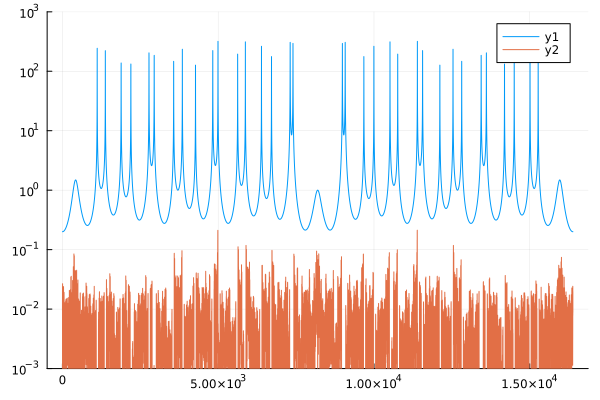

In [13]:
@show norm(gkdata_reconst2 .- gkdata)
p = plot(yscale=:log10, ylims=(1e-3, 1e+3))
plot!(p, abs.(gkdata))
plot!(p, 1e+6 * abs.(gkdata_reconst2 .- gkdata))